<center style="font-weight:bold;font-size:26px">Pericolo - Marker Detection - Aruco </center>

# Setup

## Imports

In [2]:
import os
import sys

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from skimage import feature, color, transform, io
from scipy.spatial import distance as dist
from PIL import Image, ImageDraw

In [4]:
sys.path.append(os.path.join(os.path.abspath(''), '.'))

## Global Variables

In [5]:
ROOT_FOLDER = os.path.join(os.path.abspath(''), '..')
DATA_FOLDER = os.path.join(ROOT_FOLDER, 'data')
IMG_FOLDER = os.path.join(DATA_FOLDER, 'img')
ANNOT_FOLDER = os.path.join(DATA_FOLDER, 'annotations')

# Functions definition

In [6]:
def read_img(filename, engine='cv'):
    if engine == 'cv':
        img = cv2.imread(filename)
    elif engine == 'skimage':
        img = io.imread(filename)
    return img

In [7]:
def get_img(df, idx, engine='cv'):
    print(df.loc[idx].file)
    return read_img(os.path.join(IMG_FOLDER, df.loc[idx].file), engine=engine)

## Plot functions

In [8]:
def imshow(img, figsize=(6, 6), cmap=None):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.show()

In [9]:
def imshow_masked(img, mask, figsize=(6,6), factor=0.3):
    fig = plt.figure(figsize=figsize)
    aux_img = img.astype(float)
    aux_mask = np.expand_dims(mask.astype(float)*(1-factor) + factor, axis=-1)
    drk_img = (aux_img * aux_mask).astype(np.uint8)
    plt.imshow(drk_img)
    plt.show()

## Mask generation

In [10]:
def polygon_to_mask(width, height, polygon):
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    return np.array(img)

## Detector functions

In [11]:
def drawer_detector(QueryImgBGR, trainImg, goodMatch, trainKP, queryKP, force_true = False):
    if (len(goodMatch)>=MIN_MATCH_COUNT) or force_true:
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,(0,255,0),5)
        print("Match Found")
        return trainBorder, queryBorder
    else:
        print("Not Enough match found-")
        print(len(goodMatch),MIN_MATCH_COUNT)
        return None

## Warp functions

In [12]:
def vector_representation(lines):
    locations = []
    directions = []
    strengths = []
    
    # For each detected line of 2 points
    for a,b in lines:
        a,b = np.array(a), np.array(b)
        locations.append((a + b) / 2) # generate the location as the middle point
        directions.append(b - a) # compute the direction vector
        strengths.append(np.linalg.norm(b - a)) # compute the strength as the norm
    
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)
    
    directions = np.array(directions) / np.linalg.norm(directions, axis=1)[:, np.newaxis] # normalize the directions
    
    return (locations, directions, strengths)

In [13]:
def to_homogenous_geometry(locations, directions, strengths):
    normals = np.zeros_like(directions) # Compute the edglets normal vector
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1) # Create the 3rd dimension representing the same point
    return lines

In [14]:
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [15]:
def infer_warp_shape(image, vp1, vp2, clip=False, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)
    
    max_x = int(max_x)
    max_y = int(max_y)
    
    return max_x, max_y

In [16]:
def warp_image(image, vp1, vp2, clip=True, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    # Create an Offset matrix
    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    # Generate the final Homography matrix
    # by applying the offset on top of the previous matrices
    final_homography = np.dot(T, inter_matrix)

    # Generate the transformed image
    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img

In [17]:
def ransac(locations, directions, strengths, num_ransac_iter=2000, threshold_inlier=5):
    lines = to_homogenous_geometry(locations, directions, strengths) # convert to homogenous geometry

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5] # Select the top 20 percentile
    second_index_space = arg_sort[:num_pts // 2] # Select the top 50 percentile

    best_model = None
    best_votes = np.zeros(num_pts)

    # Sampling process
    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space) # Sample a line from the top 20 percentile
        ind2 = np.random.choice(second_index_space) # Sample a line from the top 50 percentile

        l1 = lines[ind1]
        l2 = lines[ind2]

        # In Homogenous geometry the cross-product (vectot product)
        # represents the intersection points between two vectors
        current_model = np.cross(l1, l2)
        
        # In case of degeneracy
        # e.g colinearity between l1 and l2
        # e.g sampling where l1 and l2 are the same line
        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # Force resampling
            continue

        # Represent Vanishing Point (Intersection Point) in (X, Y, 1) Initial Plane
        vp = current_model[:2] / current_model[2]
        
        # For each edgelet compute the angle between the direction vector
        # and the vector defined as edgelet location minus vanishing point
        est_directions = locations - vp
        dot_prod = np.sum(est_directions * directions, axis=1)
        abs_prod = np.linalg.norm(directions, axis=1) * np.linalg.norm(est_directions, axis=1)
        abs_prod[abs_prod == 0] = 1e-5
        threshold_inlier = 5
        cosine_theta = dot_prod / abs_prod
        theta = np.arccos(np.abs(cosine_theta))
        
        # Consider for scoring only the edglets within a range of +/- threshold_inlier
        theta_thresh = threshold_inlier * np.pi / 180
        # The score is equal to the sum of edgelet's strength falling in the threshold range
        current_votes = (theta < theta_thresh) * strengths
        
        # In case the new model is better, replace the old one
        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes
            print("Current best model has {} votes at iteration {}".format(
                current_votes.sum(), ransac_iter))
    return best_model

# Main Code

## Initialisation

In [18]:
#metadata_df = pd.read_csv(os.path.join(DATA_FOLDER, 'metadata.csv'), sep=';')
#metadata_df.query('type == "Aruco"').index

In [19]:
#MARKER_NAME = "aruco_marker.png"
#marker_img = io.imread(os.path.join(DATA_FOLDER, MARKER_NAME))
#imshow(marker_img)

In [20]:
#metadata_df.query('type == "Aruco"').index

In [21]:
# Load Image # GE: 12, 33, 45, 37 BE: 6, 5, 39, 43, 48
#IMG_INDEX = 52 # Select Image ID from metadata
#raw_img = get_img(metadata_df, IMG_INDEX, engine='cv') # Open Image
#raw_polygon = eval(metadata_df.loc[IMG_INDEX].polygon) # Load Ground Truth Polygon
#raw_bndbox = eval(metadata_df.loc[IMG_INDEX].bnd_box) # Load Ground Truth Bounding Box
#gt_mask = polygon_to_mask(raw_img.shape[1], raw_img.shape[0] , raw_polygon) # Generate Ground Truth Mask
#imshow(raw_img)
#imshow_masked(raw_img,gt_mask)

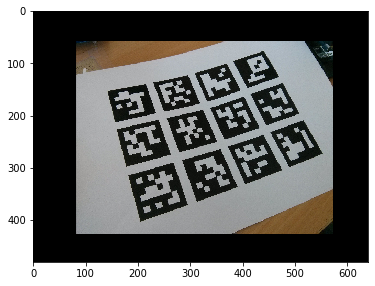

In [120]:
image = cv2.imread(os.path.join(DATA_FOLDER, 'samples', 'aruco_test.png'))
imshow(image)

## Marker detection

### Aruco Built-in OpenCV methods

[Aruco Basics in Python](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics.html)

In [121]:
from cv2 import aruco

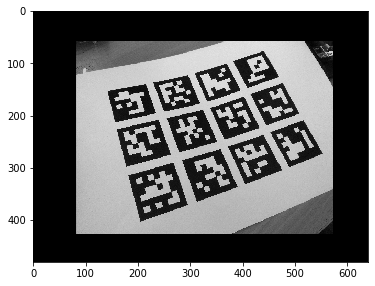

In [122]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imshow(gray, cmap='gray')

In [123]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

In [124]:
parameters =  aruco.DetectorParameters_create()

In [125]:
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

In [126]:
frame_markers = aruco.drawDetectedMarkers(image.copy(), corners, ids)

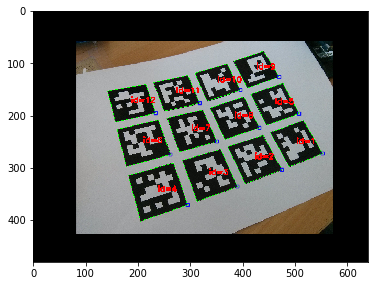

In [127]:
imshow(frame_markers)

In [128]:
corners_ordered = [order_points(marker[0]) for marker in corners]

In [129]:
corners_ordered

[array([[182., 315.],
        [268., 291.],
        [295., 371.],
        [205., 402.]], dtype=float32), array([[285., 286.],
        [358., 265.],
        [390., 336.],
        [313., 364.]], dtype=float32), array([[372., 260.],
        [439., 238.],
        [475., 304.],
        [405., 330.]], dtype=float32), array([[453., 233.],
        [516., 210.],
        [553., 273.],
        [489., 298.]], dtype=float32), array([[160., 227.],
        [239., 209.],
        [262., 275.],
        [178., 298.]], dtype=float32), array([[256., 205.],
        [324., 190.],
        [351., 250.],
        [279., 270.]], dtype=float32), array([[338., 186.],
        [402., 165.],
        [432., 224.],
        [366., 246.]], dtype=float32), array([[142., 154.],
        [215., 141.],
        [234., 196.],
        [157., 213.]], dtype=float32), array([[416., 160.],
        [477., 139.],
        [508., 197.],
        [446., 219.]], dtype=float32), array([[230., 138.],
        [295., 124.],
        [318., 177.]

## Warp

In [130]:
horizontal_lines = np.array([
    [
        [marker[0], marker[1]],
        [marker[3], marker[2]],
    ]
    for marker in corners_ordered
])
vertical_lines = np.array([
    [
        [marker[3], marker[0]],
        [marker[2], marker[1]],
    ]
    for marker in corners_ordered
])

horizontal_lines = np.array(horizontal_lines).reshape(horizontal_lines.shape[0]*horizontal_lines.shape[1], 2, 2)
vertical_lines = np.array(vertical_lines).reshape(vertical_lines.shape[0]*vertical_lines.shape[1], 2, 2)


vertical_edgelets = vector_representation(vertical_lines)
horizontal_edgelets = vector_representation(horizontal_lines)

In [131]:
vph = ransac(*horizontal_edgelets)

Current best model has 1203.57421875 votes at iteration 0
Current best model has 1360.30078125 votes at iteration 2
Current best model has 1679.0164794921875 votes at iteration 6
Current best model has 1747.72607421875 votes at iteration 211


/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in arccos
/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


In [132]:
vpv = ransac(*vertical_edgelets)

Current best model has 1640.6025390625 votes at iteration 0


/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in arccos
/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


In [133]:
image_result = warp_image(image, vpv, vph)

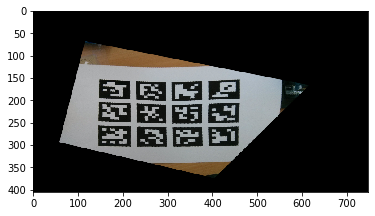

In [134]:
imshow(image_result)